# **Import Libraries**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Read Document To Be Scanned**

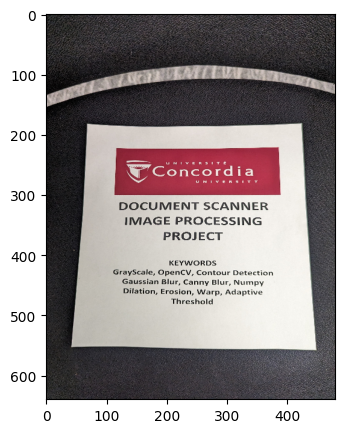

In [ ]:
testImage = '/content/gdrive/MyDrive/IPProject/document.jpg'
imageHeight = 640
imageWidth = 480
image = cv2.imread(testImage)
image = cv2.resize(image, (imageWidth, imageHeight))  # RESIZE IMAGE

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# **Pre Process The Image**

## **1. Convert Image To Gray Scale**

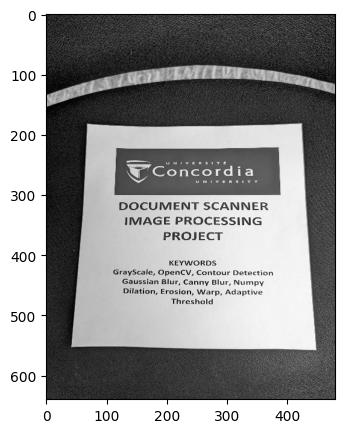

In [ ]:
grayScaleImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # CONVERT IMAGE TO GRAY SCALE

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cv2.cvtColor(grayScaleImage, cv2.COLOR_BGR2RGB))
plt.show()

## **2. Apply Blur And Minimize Noise**

 **Gaussian Blur**

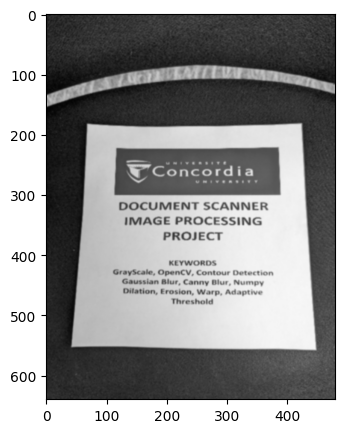

In [ ]:
gaussianBlurImage = cv2.GaussianBlur(grayScaleImage, (5, 5), 1)  # ADD GAUSSIAN BLUR
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cv2.cvtColor(gaussianBlurImage, cv2.COLOR_BGR2RGB))
plt.show()


**Canny Edge Detection**

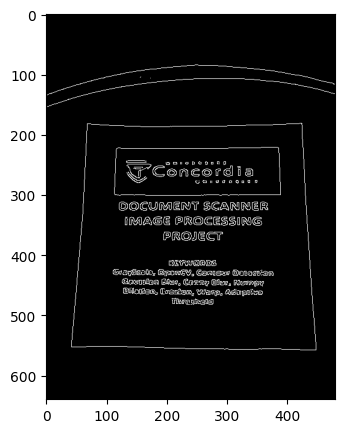

In [ ]:
cannyBlurImage = cv2.Canny(gaussianBlurImage, 200, 200)  # APPLY CANNY BLUR
kernel = np.ones((5, 5))
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cv2.cvtColor(cannyBlurImage, cv2.COLOR_BGR2RGB))
plt.show()

**Image Dialation**

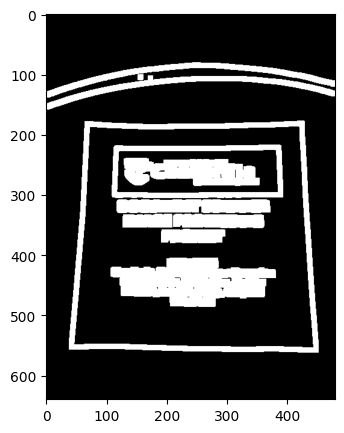

In [ ]:

# Below steps help remove noise
dialatedImage = cv2.dilate(cannyBlurImage, kernel, iterations=2)  # APPLY DILATION
fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cv2.cvtColor(dialatedImage, cv2.COLOR_BGR2RGB))
plt.show()

**Image Erosion**

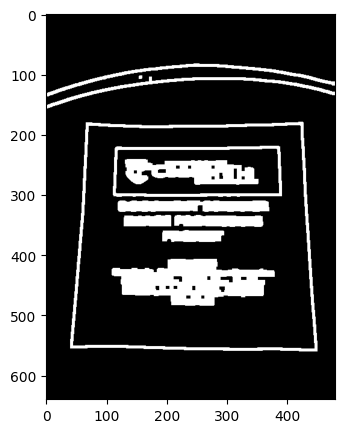

In [ ]:
errosionImage = cv2.erode(dialatedImage, kernel, iterations=1)  # APPLY EROSION

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cv2.cvtColor(errosionImage, cv2.COLOR_BGR2RGB))
plt.show()

# **Find All Contours**

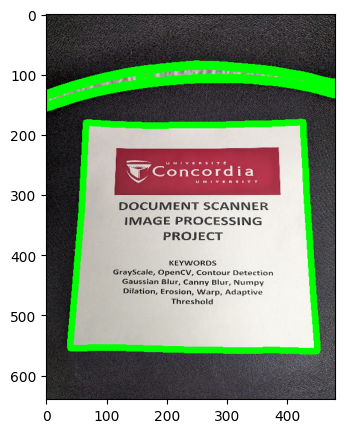

In [ ]:
# Find all contours
imageContours = image.copy()  # COPY IMAGE FOR DISPLAY PURPOSES
biggestContourInImage = image.copy()  # COPY IMAGE FOR DISPLAY PURPOSES

# RETR_EXTERNAL gives best results if we are trying to find outer methods
contours, hierarchy = cv2.findContours(errosionImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # FIND ALL CONTOURS
cv2.drawContours(imageContours, contours, -1, (0, 255, 0), 10)  # DRAW ALL DETECTED CONTOURS

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(cv2.cvtColor(imageContours, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
def findBiggestContour(contours):
    biggestContour = np.array([])
    maximumArea = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 5000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.02 * peri, True)
            # check if it is a rectangle by checking if it has 4 edges
            if area > maximumArea and len(approx) == 4:
                biggestContour = approx
                maximumArea = area
    return biggestContour,maximumArea

In [ ]:
def reorderBiggestContourVertices(points):

    contourPoints = points.reshape((4, 2))
    newContourPoints = np.zeros((4, 1, 2), dtype=np.int32)
    add = contourPoints.sum(1)

    newContourPoints[0] = contourPoints[np.argmin(add)]
    newContourPoints[3] =contourPoints[np.argmax(add)]
    diff = np.diff(contourPoints, axis=1)
    newContourPoints[1] =contourPoints[np.argmin(diff)]
    newContourPoints[2] = contourPoints[np.argmax(diff)]

    return newContourPoints

In [ ]:
def drawRectangle(image, biggestContour, thickness):
    cv2.line(image, (biggestContour[0][0][0], biggestContour[0][0][1]), (biggestContour[1][0][0], biggestContour[1][0][1]), (0, 255, 0), thickness)
    cv2.line(image, (biggestContour[0][0][0], biggestContour[0][0][1]), (biggestContour[2][0][0], biggestContour[2][0][1]), (0, 255, 0), thickness)
    cv2.line(image, (biggestContour[3][0][0], biggestContour[3][0][1]), (biggestContour[2][0][0], biggestContour[2][0][1]), (0, 255, 0), thickness)
    cv2.line(image, (biggestContour[3][0][0], biggestContour[3][0][1]), (biggestContour[1][0][0], biggestContour[1][0][1]), (0, 255, 0), thickness)

    return image

# **FIND THE BIGGEST CONTOUR**

**Mark Biggest Contour**

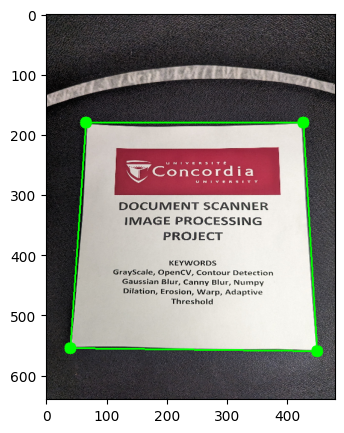

In [ ]:
biggestContour, maximumArea = findBiggestContour(contours) 
if biggestContour.size != 0:
    biggestContour = reorderBiggestContourVertices(biggestContour)
    cv2.drawContours(biggestContourInImage, biggestContour, -1, (0, 255, 0), 20)  # DRAW THE BIGGEST CONTOUR
    biggestContourInImage = drawRectangle(biggestContourInImage, biggestContour, 2)
    
    biggestContourInImage = cv2.cvtColor(biggestContourInImage, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.imshow(biggestContourInImage)
    plt.show()

**Extract Image to Warp based on Biggest Contour**

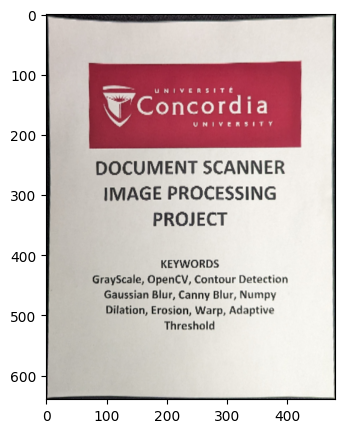

In [ ]:
    # Points from the Biggest Contour
    pointsForBiggestContour = np.float32(biggestContour)

    # PREPARE POINTS FOR WARP, the 4 points before applying the warp perspective
    pointsForWarp = np.float32([[0, 0], [imageWidth, 0], [0, imageHeight], [imageWidth, imageHeight]])
    
    matrix = cv2.getPerspectiveTransform(pointsForBiggestContour, pointsForWarp)
    coloredImageWarpped = cv2.warpPerspective(image, matrix, (imageWidth, imageHeight))

    coloredImageWarppedForPrint = cv2.cvtColor(coloredImageWarpped, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.imshow(coloredImageWarppedForPrint)
    plt.show()

**Remove Pixels from Edges to make edges smooth**

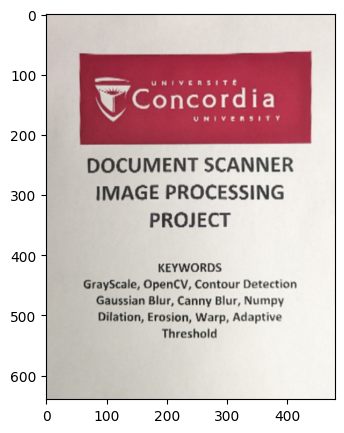

In [ ]:
    # REMOVE 20 PIXELS FROM EACH SIDE so that bends of paper are removed
    warppedImageWithRemovedEdgePixels = coloredImageWarpped[20:coloredImageWarpped.shape[0] - 20, 20:coloredImageWarpped.shape[1] - 20]
    warppedImageWithRemovedEdgePixels = cv2.resize(warppedImageWithRemovedEdgePixels, (imageWidth, imageHeight))

    warppedImageWithRemovedEdgePixelsForPrint = cv2.cvtColor(warppedImageWithRemovedEdgePixels, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.imshow(warppedImageWithRemovedEdgePixelsForPrint)
    plt.show()

**Apply Adaptive Threshold**

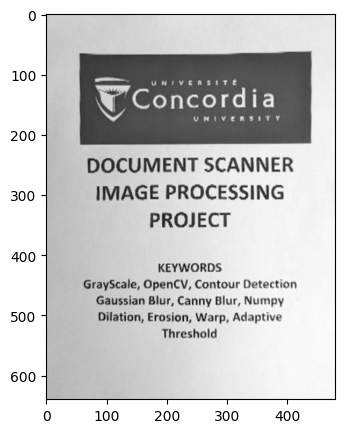

In [ ]:
    # APPLY ADAPTIVE THRESHOLD, to get a more paper like feel and to convert to black and white
    warppedImageGray = cv2.cvtColor(warppedImageWithRemovedEdgePixels, cv2.COLOR_BGR2GRAY)
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.imshow(warppedImageGray, cmap='gray')
    plt.show()

**Convert Image to Binary Image**

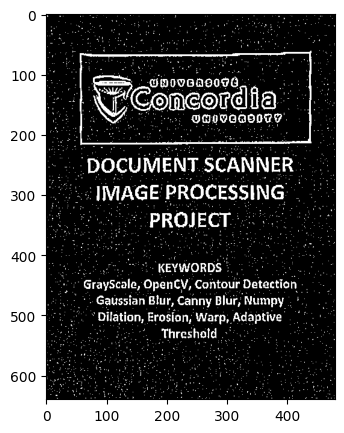

In [ ]:
    # apply below method to get binary image
    binaryImage = cv2.adaptiveThreshold(warppedImageGray, 255, 1, 1, 7, 2)
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.imshow(binaryImage, cmap='gray')
    plt.show()  

**Inverse all 0s and 1s in Binary Image**

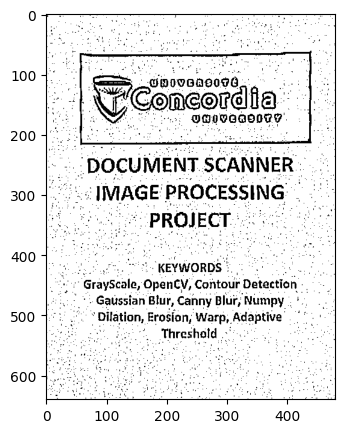

In [ ]:
    # Make all 0s 1s and all 1s 0s to get our image
    inversedBinaryImage = cv2.bitwise_not(binaryImage)
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.imshow(inversedBinaryImage, cmap='gray')
    plt.show()

**Apply Median Blur to Remove Salt and Pepper Noise from Adaptive Threshold**

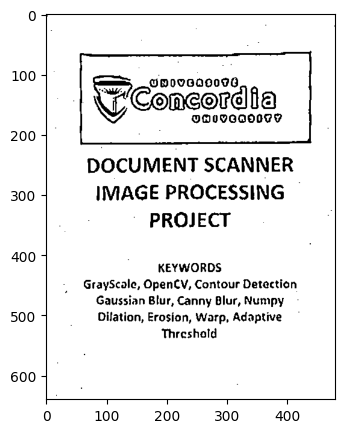

In [ ]:
    # sometimes adaptiveThreshold gives us noise , so we use medianBlur to remove salt and pepper noise
    medianBlurBinaryImage = cv2.medianBlur(inversedBinaryImage, 3)
    fig, axs = plt.subplots(figsize=(5, 5))
    axs.imshow(medianBlurBinaryImage, cmap='gray')
    plt.show()

# **Display Result Images**

In [ ]:
# Convert color space to RGB
originallyScannedImage = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
coloredImageWarpped = cv2.cvtColor(coloredImageWarpped, cv2.COLOR_BGR2RGB)
imgAdaptiveThre = cv2.cvtColor(medianBlurBinaryImage, cv2.COLOR_BGR2RGB)

**Originally Scanned Image ----> Warpped Image Colored/Adaptive Threshold**

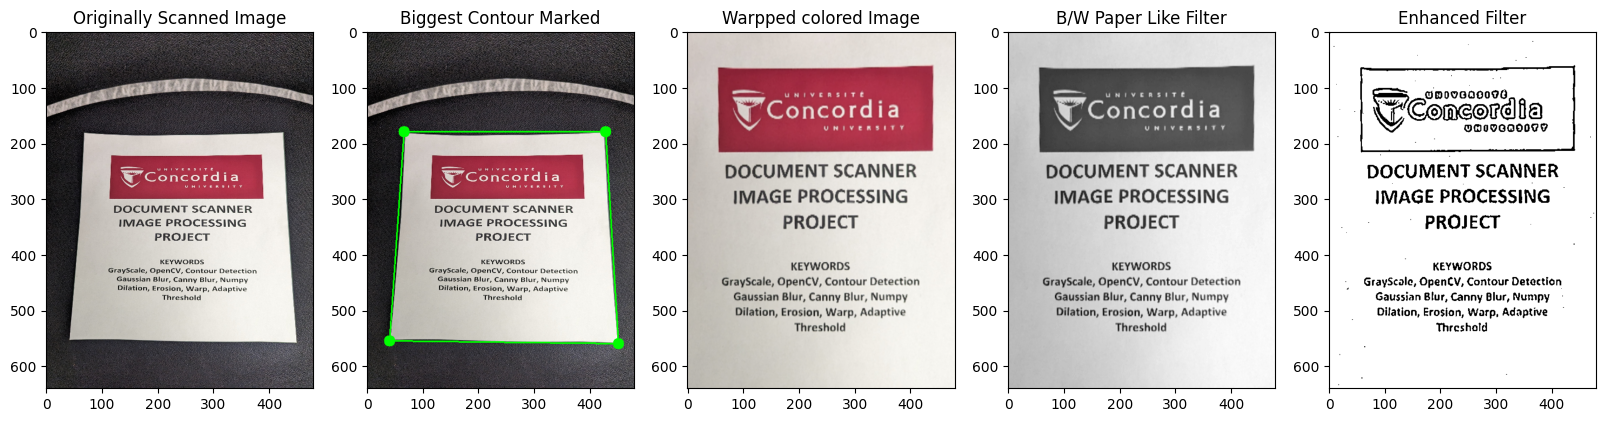

In [ ]:
# Create subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 20))

# Display images
axs[0].imshow(originallyScannedImage)
axs[0].set_title('Originally Scanned Image')

axs[1].imshow(biggestContourInImage)
axs[1].set_title('Biggest Contour Marked')

axs[2].imshow(warppedImageWithRemovedEdgePixelsForPrint)
axs[2].set_title('Warpped colored Image')

axs[3].imshow(warppedImageGray, cmap="gray")
axs[3].set_title('B/W Paper Like Filter')

axs[4].imshow(medianBlurBinaryImage, cmap="gray")
axs[4].set_title('Enhanced Filter')

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.2)

plt.savefig("test_1.png",dpi=100)
# Show the subplots
plt.show()